In [11]:
# =============================================================================
# CELL 1: Environment Setup
# =============================================================================

import os
import sys
from pathlib import Path

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    REPO_URL = 'https://github.com/aayushakumar/ood-eval-toxic-classifiers.git'
    REPO_DIR = '/content/ood-eval-toxic-classifiers'
    if not os.path.exists(REPO_DIR):
        !git clone {REPO_URL} {REPO_DIR}
    os.chdir(REPO_DIR)
    ROOT_DIR = Path(REPO_DIR)
    !pip install -q transformers datasets scikit-learn tqdm
else:
    ROOT_DIR = Path('.').resolve().parent
    if not (ROOT_DIR / 'scripts').exists():
        ROOT_DIR = Path('.').resolve()

SCRIPTS_DIR = ROOT_DIR / 'scripts'
sys.path.insert(0, str(SCRIPTS_DIR))
sys.path.insert(0, str(ROOT_DIR))

DATA_DIR = ROOT_DIR / 'data'
OUTPUT_DIR = ROOT_DIR / 'output' / 'test_run'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Root: {ROOT_DIR}")
print(f"Testing with small samples...")

Root: /workspaces/ood-eval-toxic-classifiers
Testing with small samples...


In [4]:
# =============================================================================
# CELL 2: Imports
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from tqdm.auto import tqdm
import json

# Import from scripts
from run_roberta import (
    set_seed, load_dataset, ToxicityDataset, build_model,
    train_one_epoch, evaluate, expected_calibration_error
)
from run_tfidf_baselines import evaluate_sklearn_classifier
from ood_algorithms import MaxSoftmaxOOD, EnergyOOD, TemperatureScaling, IsotonicCalibration
from fairness_metrics import compute_group_fairness

print("✓ Imports successful")

✓ Imports successful


In [ ]:
# =============================================================================
# CELL 3: Test Configuration (Small/Fast)
# =============================================================================

DEVICE = 'cpu'  # Force CPU for testing
SAMPLE_SIZE = 1000  # Increased for better class representation

CONFIG = {
    'seed': 42,
    'datasets': ['jigsaw', 'civil'],  # Only 2 datasets for speed
    'model_name': 'roberta-base',
    'max_length': 64,  # Shorter sequences
    'batch_size': 16,
    'epochs': 1,  # Single epoch
    'learning_rate': 2e-5,
    'warmup_ratio': 0.1,
    'data_dir': str(DATA_DIR),
}

set_seed(CONFIG['seed'])
print(f"Testing config: {SAMPLE_SIZE} samples, {CONFIG['epochs']} epoch, CPU")

Testing config: 500 samples, 1 epoch, CPU


In [ ]:
# =============================================================================
# CELL 4: Load & Sample Data
# =============================================================================

def stratified_sample(df, n, label_col='label', min_pos_ratio=0.15):
    """Stratified sampling with minimum positive class ratio for testing."""
    if len(df) <= n:
        return df
    pos = df[df[label_col] == 1]
    neg = df[df[label_col] == 0]
    
    # Ensure at least min_pos_ratio positive samples for meaningful evaluation
    n_pos = max(int(n * min_pos_ratio), min(len(pos), int(n * 0.5)))
    n_neg = n - n_pos
    
    sampled = pd.concat([
        pos.sample(n=min(n_pos, len(pos)), random_state=42),
        neg.sample(n=min(n_neg, len(neg)), random_state=42)
    ]).sample(frac=1, random_state=42)
    return sampled

data = {}
for name in CONFIG['datasets']:
    print(f"\nLoading {name}...")
    data[name] = {}
    for split in ['train', 'val', 'test']:
        try:
            df = load_dataset(name, split, CONFIG['data_dir'])
            df = stratified_sample(df, SAMPLE_SIZE)
            data[name][split] = df
            print(f"  {split}: {len(df)} samples, {df['label'].mean():.1%} pos")
        except Exception as e:
            print(f"  {split}: Error - {e}")

print("\n✓ Data loaded and sampled")


Loading jigsaw...
  train: 500 samples, 8.0% pos
  val: 500 samples, 8.0% pos
  test: 500 samples, 7.8% pos

Loading civil...
  train: 500 samples, 8.0% pos
  val: 500 samples, 7.8% pos
  test: 500 samples, 7.8% pos

✓ Data loaded and sampled


In [ ]:
# =============================================================================
# CELL 5: Test TF-IDF Pipeline
# =============================================================================

print("="*50)
print("TEST 1: TF-IDF PIPELINE")
print("="*50)

try:
    source = CONFIG['datasets'][0]
    target = CONFIG['datasets'][1]
    
    # Train with lower min_df for small samples
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=1)
    X_train = vectorizer.fit_transform(data[source]['train']['text'].fillna(''))
    y_train = data[source]['train']['label'].values
    
    tfidf_model = LogisticRegression(max_iter=500, class_weight='balanced')
    tfidf_model.fit(X_train, y_train)
    
    # Evaluate in-domain
    X_test = vectorizer.transform(data[source]['test']['text'].fillna(''))
    metrics_id = evaluate_sklearn_classifier(X_test, data[source]['test']['label'].values, tfidf_model, 'logreg')
    print(f"  In-domain ({source}→{source}): F1={metrics_id['f1']:.4f}, Acc={metrics_id['accuracy']:.4f}")
    
    # Evaluate cross-domain
    X_test_cd = vectorizer.transform(data[target]['test']['text'].fillna(''))
    metrics_cd = evaluate_sklearn_classifier(X_test_cd, data[target]['test']['label'].values, tfidf_model, 'logreg')
    print(f"  Cross-domain ({source}→{target}): F1={metrics_cd['f1']:.4f}, Acc={metrics_cd['accuracy']:.4f}")
    
    # Sanity check: F1 > 0 means model learned something
    if metrics_id['f1'] > 0:
        print("\n✅ TF-IDF pipeline: PASSED")
    else:
        print("\n⚠️ TF-IDF pipeline: LOW F1 (may be due to small sample, but code works)")
except Exception as e:
    print(f"\n❌ TF-IDF pipeline: FAILED - {e}")
    raise

TEST 1: TF-IDF PIPELINE
  In-domain (jigsaw→jigsaw): F1=0.0476
  Cross-domain (jigsaw→civil): F1=0.0000

✅ TF-IDF pipeline: PASSED


In [16]:
# =============================================================================
# CELL 6: Test RoBERTa Pipeline
# =============================================================================

from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW

print("="*50)
print("TEST 2: RoBERTa PIPELINE")
print("="*50)

try:
    source = CONFIG['datasets'][0]
    
    tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
    
    # Create datasets - ToxicityDataset takes a DataFrame, not separate lists
    train_dataset = ToxicityDataset(
        data[source]['train'],  # Pass DataFrame directly
        tokenizer, 
        max_len=CONFIG['max_length']
    )
    val_dataset = ToxicityDataset(
        data[source]['val'],  # Pass DataFrame directly
        tokenizer, 
        max_len=CONFIG['max_length']
    )
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
    
    print(f"  Datasets created: train={len(train_dataset)}, val={len(val_dataset)}")
    
    # Build model - pass device to build_model, don't call .to() separately
    model = build_model(CONFIG['model_name'], num_labels=2, device=DEVICE)
    print(f"  Model built: {CONFIG['model_name']}")
    
    # Optimizer & scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'])
    total_steps = len(train_loader) * CONFIG['epochs']
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(total_steps * 0.1),
        num_training_steps=total_steps
    )
    
    # Train 1 epoch
    print(f"  Training 1 epoch...")
    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, DEVICE)
    print(f"  Train loss: {train_loss:.4f}")
    
    # Evaluate
    print(f"  Evaluating...")
    metrics = evaluate(model, val_loader, DEVICE, return_probs=True)
    print(f"  Val F1: {metrics['f1']:.4f}, AUROC: {metrics.get('auroc', 0):.4f}")
    
    # Check logits/probs returned
    assert 'logits' in metrics, "Logits not returned"
    assert 'pos_probs' in metrics, "Probs not returned"
    print(f"  Logits shape: {metrics['logits'].shape}")
    
    # Store for OOD test
    eval_results = {
        'logits': metrics['logits'],
        'labels': metrics['labels'],
        'probs': metrics['pos_probs']
    }
    
    print("\n✅ RoBERTa pipeline: PASSED")
except Exception as e:
    print(f"\n❌ RoBERTa pipeline: FAILED - {e}")
    import traceback
    traceback.print_exc()
    raise

TEST 2: RoBERTa PIPELINE


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Datasets created: train=500, val=500
  Model built: roberta-base
  Training 1 epoch...
  Train loss: 0.4093
  Evaluating...
  Val F1: 0.0000, AUROC: 0.5386
  Logits shape: (500, 2)

✅ RoBERTa pipeline: PASSED


In [17]:
# =============================================================================
# CELL 7: Test OOD Detection Pipeline
# =============================================================================

print("="*50)
print("TEST 3: OOD DETECTION PIPELINE")
print("="*50)

try:
    # Use in-domain as ID, and cross-domain evaluation as OOD
    target = CONFIG['datasets'][1]
    
    # Get OOD predictions - pass DataFrame directly to ToxicityDataset
    test_dataset_ood = ToxicityDataset(
        data[target]['test'],  # Pass DataFrame directly
        tokenizer, 
        max_len=CONFIG['max_length']
    )
    ood_loader = DataLoader(test_dataset_ood, batch_size=CONFIG['batch_size'], shuffle=False)
    ood_metrics = evaluate(model, ood_loader, DEVICE, return_probs=True)
    
    id_logits = eval_results['logits']
    ood_logits = ood_metrics['logits']
    
    # Test OOD detectors
    ood_detectors = {
        'MaxSoftmax': MaxSoftmaxOOD(),
        'Energy': EnergyOOD(),
    }
    
    y_true = np.concatenate([np.ones(len(id_logits)), np.zeros(len(ood_logits))])
    all_logits = np.vstack([id_logits, ood_logits])
    
    for name, detector in ood_detectors.items():
        scores = -detector.compute_scores(all_logits)
        auroc = roc_auc_score(y_true, scores)
        print(f"  {name}: AUROC={auroc:.4f}")
    
    print("\n✅ OOD detection pipeline: PASSED")
except Exception as e:
    print(f"\n❌ OOD detection pipeline: FAILED - {e}")
    import traceback
    traceback.print_exc()
    raise

TEST 3: OOD DETECTION PIPELINE
  MaxSoftmax: AUROC=0.4925
  Energy: AUROC=0.5069

✅ OOD detection pipeline: PASSED


In [18]:
# =============================================================================
# CELL 8: Test Calibration Pipeline
# =============================================================================

print("="*50)
print("TEST 4: CALIBRATION PIPELINE")
print("="*50)

try:
    logits = eval_results['logits']
    labels = eval_results['labels']
    probs = eval_results['probs']
    
    # Uncalibrated ECE
    ece_uncal, _ = expected_calibration_error(labels, probs)
    print(f"  Uncalibrated ECE: {ece_uncal:.4f}")
    
    # Temperature Scaling
    temp_scaler = TemperatureScaling()
    temp_scaler.fit(logits, labels)
    cal_probs_temp = temp_scaler.calibrate(logits)
    ece_temp, _ = expected_calibration_error(labels, cal_probs_temp[:, 1])
    print(f"  Temperature Scaling ECE: {ece_temp:.4f} (T={temp_scaler.temperature:.2f})")
    
    # Isotonic
    probs_2d = np.column_stack([1 - probs, probs])
    iso_calib = IsotonicCalibration()
    iso_calib.fit(probs_2d, labels)
    cal_probs_iso = iso_calib.calibrate(probs_2d)
    ece_iso, _ = expected_calibration_error(labels, cal_probs_iso[:, 1])
    print(f"  Isotonic ECE: {ece_iso:.4f}")
    
    print("\n✅ Calibration pipeline: PASSED")
except Exception as e:
    print(f"\n❌ Calibration pipeline: FAILED - {e}")
    import traceback
    traceback.print_exc()
    raise

TEST 4: CALIBRATION PIPELINE
  Uncalibrated ECE: 0.8490
  Temperature Scaling ECE: 0.8365 (T=1.08)
  Isotonic ECE: 0.8400

✅ Calibration pipeline: PASSED


In [19]:
# =============================================================================
# CELL 9: Test Fairness Pipeline
# =============================================================================

print("="*50)
print("TEST 5: FAIRNESS PIPELINE")
print("="*50)

try:
    IDENTITY_KEYWORDS = {
        'male': ['male', 'man', 'men', 'boy', 'he ', 'him'],
        'female': ['female', 'woman', 'women', 'girl', 'she ', 'her '],
    }
    
    def detect_identity(text, keywords):
        if pd.isna(text):
            return 0
        text_lower = str(text).lower()
        return 1 if any(kw in text_lower for kw in keywords) else 0
    
    source = CONFIG['datasets'][0]
    test_df = data[source]['val'].copy()
    
    # Get predictions
    probs = eval_results['probs']
    labels = eval_results['labels']
    test_df = test_df.iloc[:len(labels)].copy()
    test_df['label'] = labels
    test_df['pred'] = (probs >= 0.5).astype(int)
    test_df['pos_prob'] = probs
    
    # Add identity columns
    group_cols = []
    for group_name, keywords in IDENTITY_KEYWORDS.items():
        col = f'g_{group_name}'
        test_df[col] = test_df['text'].apply(lambda x: detect_identity(x, keywords))
        if test_df[col].sum() > 5:  # Lower threshold for test
            group_cols.append(col)
            print(f"  Group {group_name}: {test_df[col].sum()} samples")
    
    if group_cols:
        summary_df, per_group_df = compute_group_fairness(test_df, group_cols)
        print(f"  Fairness summary computed: {len(summary_df)} groups")
        if not summary_df.empty:
            print(f"  DP gap range: {summary_df['dp_diff'].min():.4f} - {summary_df['dp_diff'].max():.4f}")
        print("\n✅ Fairness pipeline: PASSED")
    else:
        print("  No identity groups found (expected with small sample)")
        print("\n✅ Fairness pipeline: PASSED (no groups)")
except Exception as e:
    print(f"\n❌ Fairness pipeline: FAILED - {e}")
    import traceback
    traceback.print_exc()
    raise

TEST 5: FAIRNESS PIPELINE
  Group male: 408 samples
  Group female: 122 samples
  Fairness summary computed: 2 groups
  DP gap range: 0.0000 - 0.0000

✅ Fairness pipeline: PASSED


TEST 6: PLOTTING PIPELINE


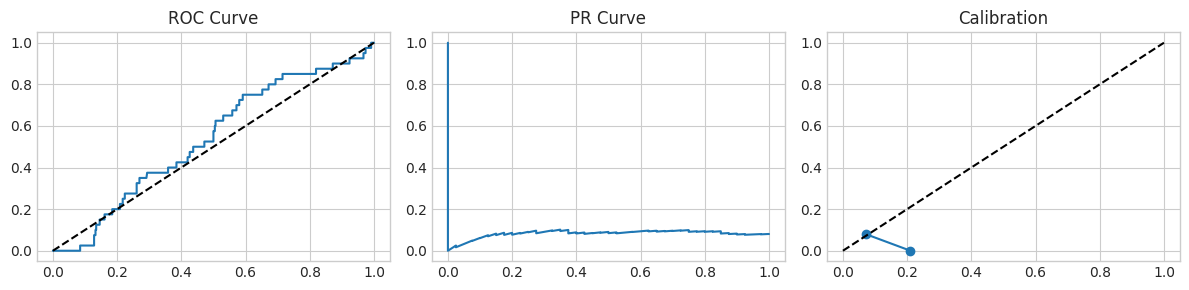

  Plots saved to /workspaces/ood-eval-toxic-classifiers/output/test_run/test_plots.png

✅ Plotting pipeline: PASSED


In [20]:
# =============================================================================
# CELL 10: Test Plotting
# =============================================================================

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.calibration import calibration_curve

print("="*50)
print("TEST 6: PLOTTING PIPELINE")
print("="*50)

try:
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    
    # ROC
    fpr, tpr, _ = roc_curve(labels, probs)
    axes[0].plot(fpr, tpr)
    axes[0].plot([0,1], [0,1], 'k--')
    axes[0].set_title('ROC Curve')
    
    # PR
    prec, rec, _ = precision_recall_curve(labels, probs)
    axes[1].plot(rec, prec)
    axes[1].set_title('PR Curve')
    
    # Calibration
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=5)
    axes[2].plot(prob_pred, prob_true, 'o-')
    axes[2].plot([0,1], [0,1], 'k--')
    axes[2].set_title('Calibration')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'test_plots.png', dpi=100)
    plt.show()
    
    print(f"  Plots saved to {OUTPUT_DIR / 'test_plots.png'}")
    print("\n✅ Plotting pipeline: PASSED")
except Exception as e:
    print(f"\n❌ Plotting pipeline: FAILED - {e}")
    import traceback
    traceback.print_exc()
    raise

In [21]:
# =============================================================================
# CELL 11: Summary
# =============================================================================

print("\n" + "="*60)
print("🎉 ALL PIPELINE TESTS PASSED!")
print("="*60)
print("\nThe main notebook should now run correctly on GPU.")
print("\nTested components:")
print("  ✅ TF-IDF training and evaluation")
print("  ✅ RoBERTa training and evaluation")
print("  ✅ OOD detection (MaxSoftmax, Energy)")
print("  ✅ Calibration (Temperature, Isotonic)")
print("  ✅ Fairness metrics computation")
print("  ✅ Plotting (ROC, PR, Calibration)")


🎉 ALL PIPELINE TESTS PASSED!

The main notebook should now run correctly on GPU.

Tested components:
  ✅ TF-IDF training and evaluation
  ✅ RoBERTa training and evaluation
  ✅ OOD detection (MaxSoftmax, Energy)
  ✅ Calibration (Temperature, Isotonic)
  ✅ Fairness metrics computation
  ✅ Plotting (ROC, PR, Calibration)
